## Minimal notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

import seaborn as sns

from collections import Counter
import itertools

from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/manuelmorales/miniconda3/envs/training/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import database

In [2]:
# always use False
LOCAL = False

if LOCAL:
    f = open('data/inspire_LA.json','r')
    df = json.load(f)
    f.close()
else:
    r = requests.get('https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json')
    df = r.json()

db_master = pd.DataFrame(df)
db_master.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
0,H.Albrecht.1,Venezuela,"[{'value': 'hartwig.albrecht@desy.de', 'curren...","Albrecht, Hermann","[{'value': 'H.Albrecht.1', 'schema': 'INSPIRE ...","Unlisted, VE",912061,"{'value': 'Albrecht, Hartwig', 'preferred_name...","[{'recid': 2023395, 'year': '2021', 'citation_...",[{'record': {'$ref': 'https://inspirehep.net/a...,1018731,[]
1,D.M.B.R.1,Venezuela,None,"Bellorin, David","[{'value': 'D.M.B.R.1', 'schema': 'INSPIRE BAI'}]","Unlisted, VE",912061,"{'value': 'R., David M. Bellorin'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023397,[]
2,D.F.Mundarain.1,Chile,None,"Mundarain, Douglas F.","[{'value': 'D.F.Mundarain.1', 'schema': 'INSPI...",Catolica del Norte U.,908143,"{'value': 'Mundarain, Douglas F.'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023398,[]
3,R.Gaitan.2,Venezuela,"[{'value': 'rgaitan@uc.edu.ve', 'current': Fal...","Dominguez, Yessica","[{'value': 'R.Gaitan.2', 'schema': 'INSPIRE BA...","Unlisted, VE",912061,"{'value': 'Gaitan, Rolando', 'preferred_name':...","[{'recid': 1863076, 'year': '2021', 'citation_...","[{'rank': 'PHD', 'record': {'$ref': 'https://i...",1864347,[]
4,J.Ntahompagaze.1,Rwanda,None,"Ntahompagaze, Joseph","[{'value': 'J.Ntahompagaze.1', 'schema': 'INSP...","EAIFR, Kigali",1636656,"{'value': 'Ntahompagaze, Joseph'}","[{'recid': 2087212, 'year': '2022', 'citation_...",None,2087213,[]


In [3]:
# Assuming db_master['papers'] is the column with the data
# Initialize an empty list to store all concatenated entries
all_entries = []

# Iterate over each entry in the column and extend the all_entries list with the content
for entry in db_master['papers']:
    all_entries.extend(entry)

# Now all_entries contains all the dictionaries from every row concatenated together
# Create a new DataFrame from the concatenated list
df_concatenated = pd.DataFrame(all_entries)

# Display the new DataFrame
df_concatenated

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,instituion_id
0,2023395,2021,1,[quant-ph],None,H.Albrecht.1,912061
1,2068608,2022,0,[quant-ph],None,H.Albrecht.1,912061
2,2023395,2021,1,[quant-ph],None,D.M.B.R.1,912061
3,2068608,2022,0,[quant-ph],None,D.M.B.R.1,912061
4,2023395,2021,1,[quant-ph],None,D.F.Mundarain.1,908143
...,...,...,...,...,...,...,...
886006,665423,None,0,[],None,C.A.Z.Vasconcellos.1,903161
886007,757236,2008,21,[astro-ph],None,C.A.Z.Vasconcellos.1,903161
886008,298179,1990,9,[],None,C.A.Z.Vasconcellos.1,903160
886009,37443,1994,1,[hep-th],None,L.C.Albuquerque.1,903160


In [4]:
# Dropping duplicates based on the 'recid' column
df_unique = df_concatenated.drop_duplicates(subset='recid')

# Display the DataFrame without duplicates
df_unique


,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,instituion_id
0,2023395,2021,1,[quant-ph],None,H.Albrecht.1,912061
1,2068608,2022,0,[quant-ph],None,H.Albrecht.1,912061
6,1863076,2021,0,[gr-qc],1613973,R.Gaitan.2,912061
7,419811,1997,13,[hep-th],None,R.Gaitan.2,902716
8,581988,2002,1,[gr-qc],None,R.Gaitan.2,907868
...,...,...,...,...,...,...,...
885424,327203,None,0,[],None,J.Borges.1,903160
885636,862823,2009,0,[],1213080,W.L.Souza.1,903160
885680,197510,1983,0,[],None,C.Yan.2,903160
885692,1808243,2020,0,[],1212279,P.Gaspar.1,903160


In [27]:
possible_years = df_unique['year'].unique()
possible_years.sort()
print(possible_years)


['0000' '1946' '1950' '1953' '1954' '1958' '1959' '1960' '1961' '1962'
 '1963' '1965' '1966' '1967' '1968' '1969' '1970' '1971' '1972' '1973'
 '1974' '1975' '1976' '1977' '1978' '1979' '1980' '1981' '1982' '1983'
 '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013'
 '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' 'None']


In [21]:
# print first paper indexed
df_unique[df_unique['year'] == '1946']

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,instituion_id
36362,41377,1946,1,[],1213168,J.L.Massera.1,903022


In [25]:
2021-1950+1+1

73

In [56]:
# Assuming your original DataFrame is named 'df' with columns 'year' and 'citation'
# Grouping by 'year' and summing up the 'citation' values
df_year_citation_sum = df_unique.groupby('year')['citation_count'].sum().reset_index()

# Renaming the 'citation' column to something more descriptive, like 'total_citations'
df_year_citation_sum.rename(columns={'citation_count': 'total_citations'}, inplace=True)

# Display the new DataFrame
df_year_citation_sum = df_year_citation_sum[1:-2]


In [68]:
# map the years to numbers
df_year_citation_sum['year'] = pd.to_numeric(df_year_citation_sum['year'])

In [69]:
df_year_citation_sum

,year,total_citations
1,1946,1
2,1950,16
3,1953,256
4,1954,111
5,1958,7
...,...,...
63,2017,23093
64,2018,24457
65,2019,20553
66,2020,14498


Fill the remaining years with zero citations

In [70]:
# First, find out the range of years
min_year = df_year_citation_sum['year'].min()
max_year = df_year_citation_sum['year'].max()

# Create a DataFrame with all years in the range
all_years = pd.DataFrame({'year': range(min_year, max_year+1)})

# Merge the original DataFrame with the all_years DataFrame
# This will set total_citations to NaN for years that don't exist in the original DataFrame
df_full = pd.merge(all_years, df_year_citation_sum, on='year', how='left')

# Fill NaN values in total_citations with 0
df_full['total_citations'].fillna(0, inplace=True)


In [71]:
df_full

,year,total_citations
0,1946,1.0
1,1947,0.0
2,1948,0.0
3,1949,0.0
4,1950,16.0
...,...,...
71,2017,23093.0
72,2018,24457.0
73,2019,20553.0
74,2020,14498.0


# The world numbers

In [94]:
df_world = pd.read_csv('world_papers.csv')
df_world = df_world[['year', 'Citations']]
# Renaming the 'citation' column to something more descriptive, like 'total_citations'
df_world.rename(columns={'Citations': 'total_citations'}, inplace=True)
df_world = df_world[:-2]
df_world['year'] = pd.to_numeric(df_world['year'])

In [95]:
df_world

,year,total_citations
0,1946,6117
1,1947,9609
2,1948,16163
3,1949,20199
4,1950,15616
...,...,...
71,2017,562608
72,2018,515254
73,2019,461003
74,2020,410667


Take the ratio

In [96]:
df_full['percentage'] = df_full['total_citations']/df_world['total_citations']*100

In [99]:
df_full

,year,total_citations,percentage
0,1946,1.0,0.016348
1,1947,0.0,0.000000
2,1948,0.0,0.000000
3,1949,0.0,0.000000
4,1950,16.0,0.102459
...,...,...,...
71,2017,23093.0,4.104634
72,2018,24457.0,4.746591
73,2019,20553.0,4.458322
74,2020,14498.0,3.530354


In [100]:
df_full = df_full.set_index('year')

# Generate histogram

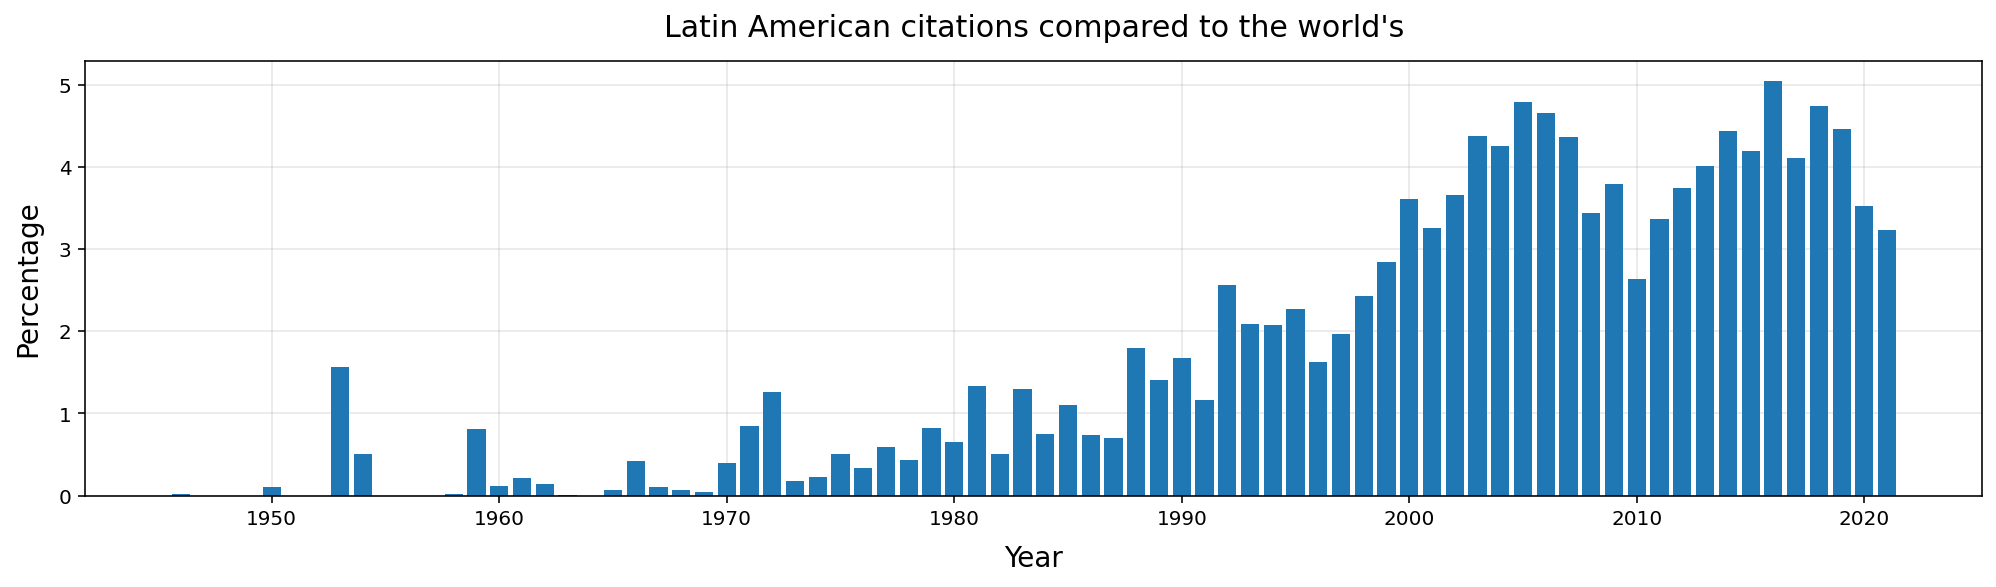

In [101]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(17,4))

# Plot the data on the axis
ax.bar(df_full.index, df_full['percentage'])

# Set the labels and title
ax.set_xlabel('Year', size=14, labelpad=8)
ax.set_ylabel('Percentage', labelpad=8, size=14)
ax.set_title(f"Latin American citations compared to the world's", size=15, pad=12)

ax.set_axisbelow(True)
ax.grid(True, alpha=0.3)

# Display the plot
plt.show()

In [102]:
# Save the figure as a PDF file
fig.savefig('../figures/world_comparison/citations_world_comparison.pdf', bbox_inches='tight')

# All countries in the database

In [3]:
# find all countries in json
all_countries = db_master['country'].unique()
# get rid of Nonetypes in the database
all_countries = [country for country in all_countries if country is not None]
# sort countries 
all_countries.sort()

print(len(all_countries))

for country in all_countries:
    print(country)
    
# format country 
def format_country(country):
    country = country.lower()
    ans = country.replace(" ", "_")
    return ans

115
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bangladesh
Belarus
Belgium
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei Darussalam
Bulgaria
Canada
Chile
China
Colombia
Congo
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Holy See (Vatican City State)
Honduras
Hungary
Iceland
India
Indonesia
Iran, Islamic Republic of
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Korea, Republic of
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lithuania
Luxembourg
Madagascar
Malaysia
Malta
Mexico
Moldova
Mongolia
Montenegro
Morocco
Netherlands
New Zealand
Niger
Nigeria
North Macedonia
Norway
Oman
Pakistan
Palestine, State of
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Russian Federation
Rwanda
Saudi Arabia
Serbia and Montenegro
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Syrian Arab Republic
Taiwan

# Latin American countries 

In [4]:
# 19 Latin American countries indexed in the database
LA_countries = [
    'Argentina',
    'Bolivia',
    'Brazil',
    'Chile',
    'Colombia',
    'Costa Rica',
    'Cuba',
    'Dominican Republic', # new
    'Ecuador',
    'El Salvador', # new
    'Guatemala',
    'Honduras',
    'Mexico',
    'Panama', # new
    'Paraguay',
    'Peru',
    'Puerto Rico', # new
    'Uruguay',
    'Venezuela'
]

# Jamaica, Bahamas not included. 

LA_countries_format = [format_country(country) for country in LA_countries]
print(LA_countries_format)

['argentina', 'bolivia', 'brazil', 'chile', 'colombia', 'costa_rica', 'cuba', 'dominican_republic', 'ecuador', 'el_salvador', 'guatemala', 'honduras', 'mexico', 'panama', 'paraguay', 'peru', 'puerto_rico', 'uruguay', 'venezuela']


# Combined dataframes of citations vs year

In [41]:
# calculate number of citations

def get_number_citations(country):
    """
    docs
    """
    # df with only the rows of the country
    db_country = db_master[db_master['country']==country].reset_index(drop=True)
    # select list of institutions of the given country
    inst_list = db_country['institution_id'].drop_duplicates().to_list()
    # define the list of dictionaries
    list_of_dicts = np.concatenate(db_country['papers'].values)
    
    # create a set to keep track of unique 'recid' values
    unique_recid_values = set()
    # create a new list to store the dictionaries with unique 'recid' values
    unique_dicts_list = []
    # create a list to store the indices of non-unique elements
    non_unique_indices = []
    # loop through the list of dictionaries and track the indices
    for index, d in enumerate(list_of_dicts):
        recid_value = d['recid']
        # check if the 'a' value is not already in the set (not a duplicate)
        if recid_value not in unique_recid_values:
            # if not, add it to the set and add the dictionary to the new list
            unique_recid_values.add(recid_value)
            unique_dicts_list.append(d)
        else:
            # if it's a duplicate, add the index to the non_unique_indices list
            non_unique_indices.append(index)
    
    # notice the typo in `instituion` in what follows
    papers_country = [element for element in unique_dicts_list if element['instituion_id'] in inst_list]
    filtered_list_of_dicts = [item for item in list_of_dicts if item['instituion_id'] in inst_list]
    
    seen_recids = set()
    filtered_data = []

    for item in filtered_list_of_dicts:
        if item['recid'] not in seen_recids:
            filtered_data.append(item)
            seen_recids.add(item['recid'])
            
    # filtered_data is the
    # list of the papers of a given country
    
    # now we calculate the citations
    total_citations = np.sum([elem['citation_count'] for elem in filtered_data])
    
    print(f"{country} = {total_citations} citations")
    #return total_citations
    
    # Create dataframe
    df_ans = pd.DataFrame(filtered_data, columns=['recid', 'year', 'citation_count'])
    
    # Setting the row index starting from 1
    df_ans.index = pd.Index(range(1, len(df_ans) + 1))
    
    
    return df_ans

In [45]:
get_number_citations('Dominican Republic')

Dominican Republic = 184 citations


,recid,year,citation_count
1,35032,1993,51
2,373019,1994,0
3,366784,1993,0
4,369157,None,0
5,401209,1995,133


In [46]:
# dictionary to store results
df_latam = {}

for country in LA_countries:
    df_latam[country] = generate_dataframe(country)


In [49]:
df_latam['Dominican Republic']

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,instituion_id
0,35032,1993,51,[gr-qc],None,Daniel.Sudarsky.1,906531
1,373019,1994,0,[],None,Daniel.Sudarsky.1,906531
2,366784,1993,0,[],None,Daniel.Sudarsky.1,907039
3,401209,1995,133,[],1214779,Daniel.Sudarsky.1,907039


In [52]:
# initialise combined dataframe
df_combined = pd.DataFrame(columns=LA_countries)

# iterate over all latam countries
for country in LA_countries:
    df_combined[country] = df_latam[country].set_index('year')
    
#df_combined = df_combined.fillna(0).astype(int)
#df_combined.head(10)

# add total paperrs
#df_combined['total'] = df_combined.sum(axis=1)

ValueError: Columns must be same length as key

In [51]:
df_combined.head(10)

,Argentina,Bolivia,Brazil,Chile,Colombia,Costa Rica,Cuba,Dominican Republic,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Panama,Paraguay,Peru,Puerto Rico,Uruguay,Venezuela
year,,,,,,,,,,,,,,,,,,,
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# dictionary to store results
df_latam = {}

for country in LA_countries:
    df_latam[country] = generate_dataframe(country)


# initialise combined dataframe
df_combined = pd.DataFrame(columns=LA_countries)

# iterate over all latam countries
for country in LA_countries:
    df_combined[country] = df_latam[country].set_index('year')
    
df_combined = df_combined.fillna(0).astype(int)
df_combined.head(10)

# add total paperrs
df_combined['total'] = df_combined.sum(axis=1)

df_combined.head(10)

In [29]:
def generate_dataframe(country):
    # select column
    db = db_master[db_master['country']==country].reset_index(drop=True)
    
    # obtain list of the institutions of the country
    inst_list = db['institution_id'].drop_duplicates().to_list()
    
    # stack papers and select the ones from the appropriate institutions
    dp = pd.DataFrame(db.papers.apply(pd.Series).stack().to_list()).reset_index(drop=True)
    dp = dp[dp['instituion_id'].isin(inst_list)]
    
    # get rid of paper duplicates
    dp = dp.drop_duplicates(subset='recid')
    
    # skip entries without listed `year`. This ignores the papers that do not have year.
    # For this reason, the sum over all years will not equal the total number of publications
    # from the other notebook. In fact, the result here will be less or equal to it. 
    dp = dp[pd.to_numeric(dp['year'], errors='coerce').notnull()].reset_index(drop=True)
    
    # transform to numerical values
    dp['year'] = pd.to_numeric(dp['year'])
    # get rid of old entries
    dp = dp[dp['year'] >= 1900]
    # get Series
    df_country = dp
    #df_country = dp['year'].value_counts().sort_index()
    #df_country = pd.DataFrame({'year': df_country.index, country: df_country.values})
    
    return df_country


In [30]:
generate_dataframe('Chile')

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,instituion_id
0,2023395,2021,1,[quant-ph],None,D.F.Mundarain.1,908143
1,2068608,2022,0,[quant-ph],None,D.F.Mundarain.1,908143
2,1445015,2019,6,[hep-th],None,M.P.Garcia.del.Moral.1,907784
3,1602193,2018,0,[hep-th],1212279,M.P.Garcia.del.Moral.1,907784
4,1859189,2022,0,[hep-th],1213103,M.P.Garcia.del.Moral.1,907784
...,...,...,...,...,...,...,...
6083,1746297,2020,2,[hep-th],None,R.Rojas.Mejias.1,904828
6084,1748760,2019,0,[],None,E.Vera.3,904828
6085,1829305,2020,6,[gr-qc],None,I.Sakalli.1,904828
6086,1242490,2013,8,[cond-mat.str-el],None,P.Mellado.2,910504


In [6]:
# example
generate_dataframe('Dominican Republic')

,year,Dominican Republic
0,1993,2
1,1994,1
2,1995,1


In [7]:
# dictionary to store results
df_latam = {}

for country in LA_countries:
    df_latam[country] = generate_dataframe(country)


In [8]:
# initialise combined dataframe
df_combined = pd.DataFrame(columns=LA_countries)

# iterate over all latam countries
for country in LA_countries:
    df_combined[country] = df_latam[country].set_index('year')
    
df_combined = df_combined.fillna(0).astype(int)
df_combined.head(10)

# add total paperrs
df_combined['total'] = df_combined.sum(axis=1)

In [9]:
df_combined.head(10)

,Argentina,Bolivia,Brazil,Chile,Colombia,Costa Rica,Cuba,Dominican Republic,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Panama,Paraguay,Peru,Puerto Rico,Uruguay,Venezuela,total
year,,,,,,,,,,,,,,,,,,,,
1960,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1961,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1966,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1967,5,0,3,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,1,14
1968,1,3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10
1969,4,1,14,3,0,0,0,0,0,1,0,0,4,0,0,2,0,1,0,30
1970,7,0,26,9,1,0,0,0,0,0,0,0,5,0,0,1,0,0,2,51
1971,21,0,30,8,0,0,0,0,0,0,0,0,13,0,0,0,0,2,6,80
1972,26,0,29,8,0,0,0,0,0,0,0,0,7,0,0,0,0,3,4,77


In [10]:
df_reduced = df_combined[['total']]
df_reduced

,total
year,
1960,1
1961,5
1966,5
1967,14
1968,10
1969,30
1970,51
1971,80
1972,77


# Load papers of the world

In [11]:
df_world = pd.read_csv('world_papers.csv')
df_world = df_world[['year', 'Citable papers']]

In [12]:
df_world = df_world.set_index('year')

In [13]:
df_world

,Citable papers
year,
1960,424
1961,430
1962,552
1963,655
1964,790
...,...
2019,34893
2020,36144
2021,39486


In [14]:
merged = df_reduced.merge(df_world, on='year', how='right', suffixes=('', '_df_world'))
merged.fillna(0, inplace=True)

In [15]:
merged

,total,Citable papers
year,,
1960,1.0,424
1961,5.0,430
1962,0.0,552
1963,0.0,655
1964,0.0,790
...,...,...
2019,1924.0,34893
2020,2109.0,36144
2021,2459.0,39486


In [16]:
# Calculate percentage
merged['percentage'] = (merged['total'] / merged['Citable papers']) * 100

# Get rid of 2023 and 2022
merged = merged.iloc[:-2]

In [17]:
merged

,total,Citable papers,percentage
year,,,
1960,1.0,424,0.235849
1961,5.0,430,1.162791
1962,0.0,552,0.000000
1963,0.0,655,0.000000
1964,0.0,790,0.000000
...,...,...,...
2017,1966.0,34830,5.644559
2018,1827.0,33026,5.532005
2019,1924.0,34893,5.514000


In [18]:
type(merged)

pandas.core.frame.DataFrame

# Obtain the histogram

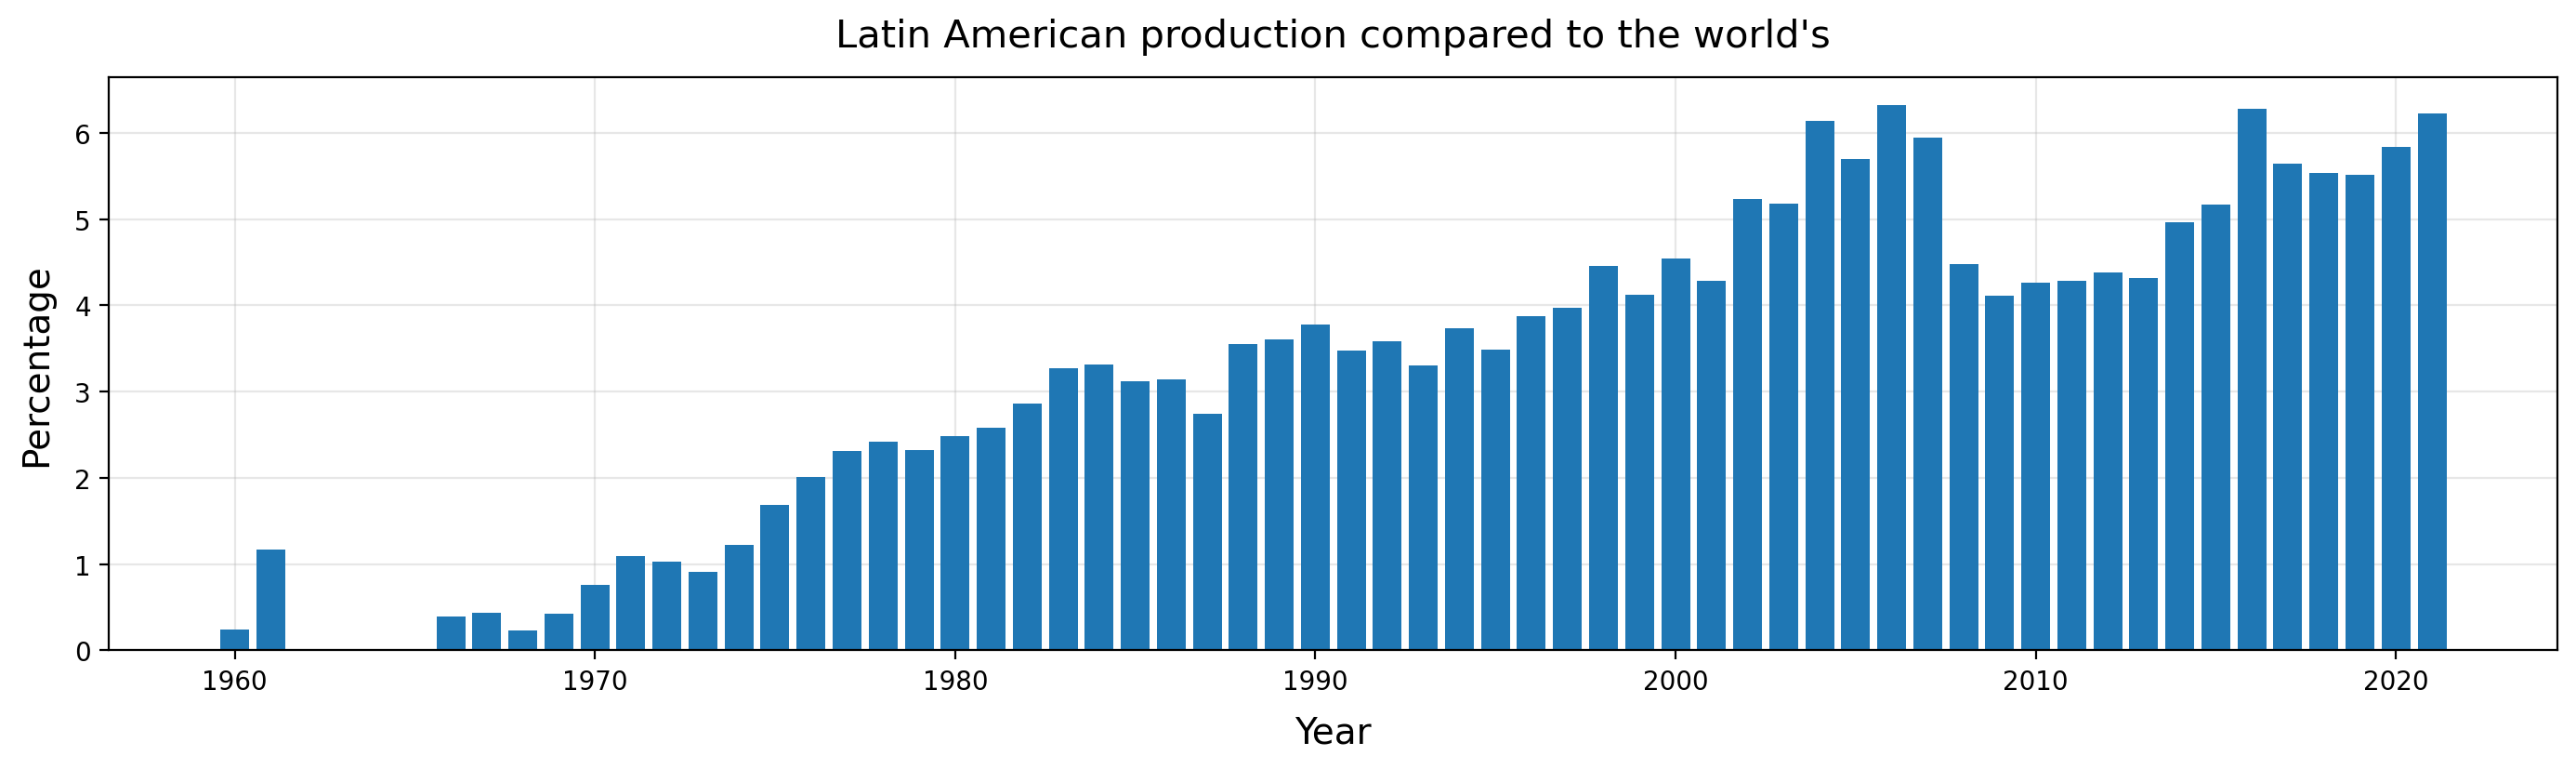

In [19]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(17,4))

# Plot the data on the axis
ax.bar(merged.index, merged['percentage'])

# Set the labels and title
ax.set_xlabel('Year', size=14, labelpad=8)
ax.set_ylabel('Percentage', labelpad=8, size=14)
ax.set_title(f"Latin American production compared to the world's", size=15, pad=12)

ax.set_axisbelow(True)
ax.grid(True, alpha=0.3)

# Display the plot
plt.show()


In [20]:
# Save the figure as a PDF file
#fig.savefig('../figures/world_comparison/papers_world_comparison.pdf', bbox_inches='tight')